In [1]:
using JuMP, Gurobi
using XLSX #for debugging purposes

include("scripts/modelGeneration.jl")
include("scripts/modelStructure.jl")
include("scripts/graphAnalysis.jl")
include("scripts/exampleModel.jl")
include("scripts/dynamicModelAnalysis.jl")
include("scripts/JuMPConstraints.jl")

calculate_embedding

# Extension of the Virtual Network Embedding formulation for Virtual Power Plants
For this project seminar, an [optimization method for Virtual Network Embeddeding (VNE) systems](https://dl.acm.org/doi/abs/10.1145/3396851.3397693) was extended to handle Virtual Power Plant (VPP) systems in order to minimize its network costs while making sure that relevant system parameters, specially the network's reliability, are fulfilled by the network embedding.<br>
VPPs are created by grouping multiple small sized power generating agents, such as solar power panels and wind turbines, together in order to form a virtual power generating unit that is able to act like a conventional power plant to outside observers.<br>
Problematic for such a system is that its members may not produce a stable power output reliably. This becomes obvious when considering renewable energy sources, where wind and light intensity may vary heavily over the day and over the seasons.

## Virtual Power Plant Model Description
As described in [this paper](https://ieeexplore.ieee.org/abstract/document/5749026?casa_token=NO80jiS3yF0AAAAA:tN12D30bR6U8XzbAaEOvB5sLWzkWbYG41GxA2ZwXTR9HycAskx-5FBffXMoox0rd0ohjrIVL), there are three kinds of networks necessary to model VPPs. 
First, an underlying electrical network is necessary, which generates the plant's defined power and distributes it accordingly. 
Second, a storage network can be used to store electricity and, if needed, to release it, thus decreasing the power fluctuation in the VPP. 
Third, a communication system capable to communicate with the VPP Management Office (VMO) is needed to monitor and control the individual member's output. All three make up the Substrate Network (SN), which is the basis of the VPP.<br>
For this project, the VPP model was further simplified by ignoring the power storage network, thus the model is described by only the electrical distribution and communication network.<br>
Both networks can be modeled as unidirected graphs $\mathcal{G} = (N,L)$, with $n_i \in N$ being the node representing the agent $i$ and $l_{ijn} \in L$ the edge with the index $n$ connecting two distinct agents $i$ and $j$. 
Thus, $N$ is the set of all nodes and $L$ the set of all edges in a given graph.<br>
The DERs that make up the VPP can be modelled as nodes in model graph. For these nodes, we can define which attributes these possess. First, these units can each produce an given mean power output $p_i$ and they also have a degree of reliability that defines how reliably it can provide power. The power-reliability dependency is in this project follows the normal distribution.<br>
Each unit also has a specific geographic location defined by its coordinates $x$ and $y$. 
Lastly, each node also possesses a cost $nc_i$ that defines the cost for activating the specific node in the network. This is necessary since we wish to optimize the network in regards to its costs.<br>
Furthermore, the edges in the graph also have attributes. The activation of both electrical distribution and communication links also costs a specific cost $c_{ij}$.<br>
Since the DERs provide both electrical and computing power to the communication network, they are consequently part of both networks. Thus, the two networks both share in this model the same DERs $n_{DER} \in N_{DER}$. But it needs to be considered that the nodes representing the infrastructure, such as mobile towers for the communication network or substations for the electrical network, differ between the two, and thus are nodes that only exist in their respecitve network graph. This means that $N_{com} \neq N_{elec}$ and $L_{com} \neq L_{elec}$.

### Electrical and Communication Network Generation
To be able to accurately simulate and to analyse optimization algorithms for VPPs, we first need to generate electrical distribution and communication models which reproduce real life properties. Both networks make up the underlying SN, on which a VNR is mapped.<br>
First, the values for all nodes in the network need to be generated. Since we calculate the power based on the normal distribution, this means that we need to generate a mean power output $p_i$ and a variance $\sigma_i$ for each power producing unit. So, the mean output power for each unit is a random value in the uniform distribution $p_i \in [\mu_u - u_p, \mu_u + u_p]$. The variance is also generated by a uniform distribution $\sigma_i \in [\sigma_u - v_p, \sigma_u + v_p]$. The DER's reliability can later be calculated based on the output power. In addition, the node activation cost for when a DER is used in a VNR is defined in this model as proportional to the generated output $c_i = \lambda_N \cdot p_i$, with $\lambda_N$ being the unit cost per kilowatt, thus $[\lambda_N] = €/kW$.<br>
Next, for the electrical distribution network, a medium to low voltage level distribution network is generated since the DERs used in a single VPP are assumed to be geographically near each other. For such type of network, normally a radial topology (also called star topology) is used to model it.<br> 
Finally, for the communication network, the star topology was also used, but, as mentioned in the previous section, the DERs have different root nodes compared to the electrical network since a different infrastructure is used for the network..<br>

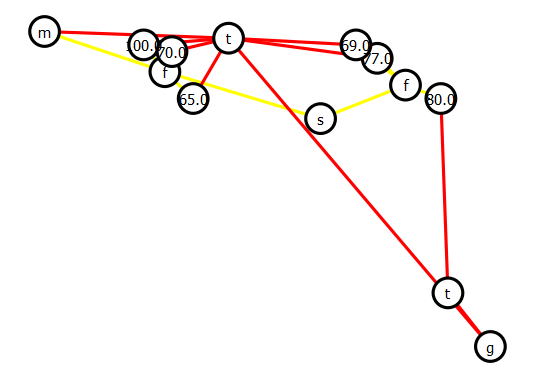

In [2]:
#define the average number of nodes in a network cluster
node_cluster = 2
#define the number of clusters in the network
cluster_sum = 3

#generate the network containing both the electrical and communication network; 
#all other values defined in the text are generated with standard values defined in the script
network = generate_network(node_cluster, cluster_sum)

#visualize the generated network with the power outputs of the individual nodes
#where the electrical connections are yellow and the communication lines are red
visualize_network(network)

### Virtual Power Plant Virtual Network Request
As the next step, an overlying network (VNR) is mapped onto the physical network, which was generated in the last section. For this, we first define how a VPP can be modelled as a VNR.<br>
The VNR can also be modelled as an Graph $G=(N',L')$ that has the virtual nodes $N'$ and the virtual links $L'$. <br>
The whole VPP is controlled by the VMO. This office is connected to all DERs by communication links. The electrical links are ignored in this model. The DERs are aggregated in the VNR to a virtual DER whose power and reliability are the defined properties of the VPP. Thus, for the VNR, we have two nodes connected to each other: The VMO and the virtual DER. As a consequence, the VNR always looks like the model graph below:<br>
<img src="fig/vnr.png" width="25%" class="center" />
Thus, to define the desired power and reliability of the VPP, we just define the virtual DER as a node with those properties.

In [3]:
#VPP properties
power = 100.0
reliability = .90

vnr = VNR(power, reliability)

VNR{Float64}(100.0, 0.9)

## Extension of the VNE algorithm for the VPP embedding problem
Now, with the generation of arbitrary models for later analyzation, we will now modify the [in this paper described method](https://dl.acm.org/doi/abs/10.1145/3396851.3397693) to deal with the VNE embedding problem for specifically the VPP use case.<br>
For this, we use the [JuMP](https://github.com/jump-dev/JuMP.jl) package for Julia. JuMP is a library for mathematical optimizations such as mixed integer linear programming, which will be used to solve this opmization problem.<br>
To solve this problem, we define the activation of nodes and edges in the substrate network as binary variables.
For nodes this can be defined as:
$$ x_i^u = \begin{cases}
    1 & \text{if the virtual node $u$ embedded onto susbstrate network node $i$} \\ 
    0 & \text{otherwise.}
\end{cases}$$
The activation of the links between the nodes $u$ and $v$ can be defined in a similar manner:
$$ y_{ij}^{uv} = \begin{cases}
    1 & \text{if the link $(i,j)$ is part of the virtual link $(u,v)$}\\ 
    0 & \text{otherwise.}
\end{cases}$$
Since we have two types of links, electrical and communication links, we thus need two types of variables, $y_{ijn,com}^{uv}$ and $y_{ijn,elec}^{uv}$. 

In [4]:
model = direct_model(Gurobi.Optimizer())
m = backend(model)

#the activation of the nodes, all defined as binary vectors
#the first x is the vmo node, the second x are the DER nodes
@variable(model, x[1:2, 1:length(network.nodes)], binary = true) 

Academic license - for non-commercial use only


2×13 Matrix{VariableRef}:
 x[1,1]  x[1,2]  x[1,3]  x[1,4]  …  x[1,10]  x[1,11]  x[1,12]  x[1,13]
 x[2,1]  x[2,2]  x[2,3]  x[2,4]     x[2,10]  x[2,11]  x[2,12]  x[2,13]

For the optimization problem, we need to define the conditions that describe the constraints of the model.
First, we define that a virtual DER-node given in the VNR can be mapped onto $m$ different nodes. This can be described with the given constraint:
$$ \sum^N_i x^{DER}_i \geq 1$$
Furthermore, we need to define that the VMO node may only be embedded once. This gives us the next equation:
$$ \sum^N_i x^{VMO}_i = 1$$
In the referenced paper, the reliability of the embedding is created by generating node redundancy by mapping $K$ embeddings of the same VNR onto the SN. Since we allow the virtual nodes to be mapped onto more than one node, we thus implicitly create redundancy with this constraint and we do not need to map $K$ embeddings to fulfill the reliability requirements. So we assume that $K = 1$.<br>
Next, we need to define the characteristics of the links between the nodes. For the embedding problem, we need to make sure that the VMO and the single DERs have a continuous connection between them. This can be ensured by the [multi-commodity flow constraint](https://ieeexplore.ieee.org/document/4567876), that defines that the given equality applies to all links mapped to the SN: 
$$ \sum_{j\in N(i)}(y_{ijn}^{uv}-y_{jin}^{uv})=x_i^u-x_i^v,\forall (u,v) \in L', \forall i\in N$$
In the equation, $N(i)$ is the set of all neighboring nodes of the node $i$. Since the VNR only has links where the sink node is the VMO, we can thus say that $x^v$ can only be the VMO node. In addition, because the virtual DER node can be mapped onto multiple physical DER nodes,  the multi-commodity flow constraint does not work with binary variables for $x^u$, only with float variables. The reason is that, for this constraint to be true, the output of all source nodes in a graph should equal to the total input of all sink nodes. If the VMO is considered the only sink node in the graph with the binary input $1$, then the total output of all DERs, that can be considered in this context as source nodes, should also be $1$. This means that $\sum^N x_{flow}^{DER} = 1$. As a consequence, this means that if the virtual DER node is mapped onto more than one physical node, then $0<x_{flow, DER}<1$. Furthermore, since the links $y^{uv}$ transport the imaginary flow of $x_{flow, DER}$, it also does not work with binary values, only with float variables.<br>
But since we need to use binary variables in later parts of our optimization problem to calculate which DER nodes need to be activated to satisfy the VPP characteristics, it is necessary to have constraints which translate the binary variables to floating point variables.<br>
For the DER node, we can calculate the floating point value by defining the constraint:
$$  x_{flow, DER} \geq x_{DER}\cdot\frac{1}{|N|}$$
The constraint defines that, if $x_{DER}$ is activated, the node's floating point value is at least the fraction of the size of the nodeset of the graph.<br>
For the links, we need to convert from floating point variables to binary variables, so that we can later know which links are activated in the VNE. For this, we can define that a link $l$ that connects the physical nodes $i$ and $j$ is activated when:
$$ y_l > |y_{flow, i,j}|\lor y_l > |y_{flow, j,i}|$$

In [5]:
#mapping constraints
# 1 = vmo, 2 = der
@constraint(model, c1, sum(x[1, i] for i in 1:length(network.nodes)) == 1)
@constraint(model, c2, sum(x[2, i] for i in 1:length(network.nodes)) >= 1)

#now we define that the vmo node must be mapped to the specific substrate vmo
#vmo constraint; the vmo should be on (x,y) = (1,1)
@constraint(model, c3[i = 1:length(network.nodes)], x[1, i] <= 1/network.nodes[i].x)
@constraint(model, c4[i = 1:length(network.nodes)], x[1, i] <= 1/network.nodes[i].y)


#calculate the vnr links
# 1 = vmo, 2 = der
links = [[1,2]]
vnr_nodes = 2

@variable(model, x_float[u = 1:vnr_nodes, i = 1:length(network.nodes)])
@variable(model, y_float[uv = 1:length(links), i = 1:length(network.nodes), j = 1:length(network.nodes)])
#multi-commodity flow constraint
@constraint(model, c5[uv = 1:length(links), i = 1:length(network.nodes)],
           sum(y_float[uv,i,j] - y_float[uv,j,i] for j in get_neighboring_com_nodes_id(network.nodes[i])) 
            == sum(x_float[links[uv][1],i] - x_float[links[uv][2],i]))

#constraints for consistency between float and binary node variables
#vmo -> no complex constraint necessary, since the floating point value is always 1
@constraint(model, c6[i = 1:length(network.nodes)], x_float[1, i] == x[1, i])
#ders
#translation from binary to floating point variables
@constraint(model, c8[i = 1:length(network.nodes)], x_float[2, i] - x[2, i]*1/length(network.nodes) >= 0)

@variable(model, y[h = 1:length(network.com_edges)], binary = true)

c = network.com_edges

#sn links; we need four constraints because y[l] >= abs(y_float[uv,l.from,l.to]) and y[l] >= abs(y_float[uv,l.to,l.from])
@constraint(model, c9[uv = 1:length(links), l = 1:length(network.com_edges)], 
            y[l] >= y_float[uv,c[l].from.id,c[l].to.id])
@constraint(model, c10[uv = 1:length(links), l = 1:length(network.com_edges)], 
            y[l] >= -y_float[uv,c[l].from.id,c[l].to.id])

@constraint(model, c11[uv = 1:length(links), l = 1:length(network.com_edges)], 
            y[l] >= y_float[uv,c[l].to.id,c[l].from.id])
@constraint(model, c12[uv = 1:length(links), l = 1:length(network.com_edges)], 
            y[l] >= -y_float[uv,c[l].to.id,c[l].from.id])

1×9 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 c12[1,1] : y_float[1,12,11] + y[1] >= 0.0  …  c12[1,9] : y_float[1,10,13] + y[9] >= 0.0

## Scenario-based reliability calculation
The VPP reliability calculation is scenario based since its reliability is dependent on the reliability of the single DER nodes and communication links. So, we first need to define how the reliability of a single DER node can be calculated in the context of the VPP. In the model generation subsection, we generated the DERs each with a mean power output and power output variance. This means that a node can produce at least an output $p_i$ with a given reliability $r_i$ that is based on the normal distribution. But this does not mean that a node will not produce anything with a probability of $1-r_i$. This just means that the real power output will be less than the expected power output $p_i$. Furthermore, this means that the node can produce at least an output $p_i'< p_i$ with a reliability $r_i'>r_i$. As a consequence, for the reliability calculation, we can handle the reliability of the DER nodes more flexibly by varying the expected power output of the DER node. So, for the reliability calculation, we will now work with varying $u_i = 1-r_i(p'_i)= P(x<p'_i)$ for each node $i$ and describes the probability $u_i$ that a node will produce less than the defined power output $p_i'$.<br>
So, we will define the scenarios in this case based on the varying power output levels of the different DERs. This means that we create for each power output level for each DER a combination of scenarios where the DER has the specific power output level. But the range of possible power outputs can be considered continuous. Thus, we discretize the space of possible output levels, only considering output levels that are reached with a reliability of $10\%$, $20\%$,.... So, for the $n$ DER nodes with $l$ predefined reliability levels that need to be considered we need to create $n^l$ scenarios since the scenarios can be calculated as the cartesian products of all reliability levels of each DER node. <br>
Then, with these scenarios the reliability of the VNE and thus the VPP is calculated. 
For each scenario, we have a tuple defining all different power outputs for each DER in the scenario. We calculate the probabilities of each scenario $\omega$ with this specific formula:
$$\pi_\omega =\prod_{n \in N}u_i$$
This means that the probability of the scenario to occur is equal to the product of the failure probability $u_i$ of all nodes in the specific scenario.<br>
Next, we create the reliability constraints with the given scenario probabilities. 
For this, we first define a binary variable $\zeta_\omega$ that indicates whether in a given scenario $\omega$ the defined power output of the VPP is reached by the VNE and $x_{n}$ indicates whether $x_{DER}$ is mapped onto $x_i$. $\zeta_\omega$ can thus be written as:
$$ \zeta_\omega = \begin{cases}
    1 & \text{if $\sum_{n \in N}p_{n,\omega}(r'_{n,\omega})x_n< p$}\\ 
    0 & \text{otherwise.}
\end{cases}$$
The equation defines that if the sum of the power output of all nodes that are part of the VNE in the scenario $\omega$ is smaller than the required power output of the VPP, then $\zeta_n=1$.<br>
This specific equation cannot be written as-is in JuMP. Thus, we redescribe the constraint as:
$$ \zeta_\omega\cdot p + \sum_{n \in N}p_{n,\omega}(r'_{n,\omega})x_n \geq p$$
The reliability of the VPP can then be calculated as the weighted sum of all scenarios where the VPP does not reach the required output. This reliability needs to be higher than the desired reliability of the VPP. The constraint is thus defined as:
$$ \sum_{\omega \in \Omega}\zeta_\omega\pi_\omega \leq 1-r$$


Next, we also need to consider that the communication between the VMO and the DERs may not be always reliable. If the VMO cannot communicate with the DER, it is considered unavailable and the power output is considered as 0 by the VMO. Since the link failure leads to specific nodes failing, this thus means that the link failure scenario is dependend on the already defined node output scenarios. Therefore, we need to expand the already defined equation to take link failures into account.<br>
$$ \zeta{\omega, l} = \begin{cases}
    1 & \text{if $\sum_{n \in N}p_{n,\omega}(r'_{n,\omega})x_n\epsilon_l(n)< p$}\\ 
    0 & \text{otherwise.}
\end{cases}$$
The variable $\epsilon_l(n)$ in the equation defines that if a node $n$ cannot be connected anymore when the link $l$ fails, then $\epsilon = 0$, else it is $1$.

Finally, we also need to expand the final reliability calculation equation to consider the link failure scenarios. 
First, we need to define the total reliability level based on the link reliabilities. For example, if a certain link never fails, then the scenario probability of all scenarios $i$ with the given link $l$ is simply $0$. Next, if a certain link always fails, so when its reliability is $0\%$, this means that if in all scenarios $i$, where the link $l$ fails, the above mentioned constraint of the power calculation fails and thus $\zeta_{i, l} = 1$, then the embedding's reliability is $0$ since it will never achieve it's desired power output.<br>
Now, knowing the probability or total reliability levels for both extreme link reliability scenarios, we can calculate the probability for each $\zeta_{\omega, l}$. For the link reliability $r_l=1$, we can calculate the total reliability as $\pi_\omega\cdot\alpha(1-r_l)$. The equation form $(1-r_l)$ was chosen since we want to make the probability linearly proportional to the link reliability. Next, when we have the link reliability $r_l=0$, then we can insert the reliability factor in the before mentioned VPP reliability equation 
$$\sum_{\omega \in \Omega}\pi_\omega\alpha=1 $$ to calculate the parameter $\alpha$ (the equation is set as 1 since it is not the reliability of the embedding that is calculated, but the failure probability $1-r_{VPP}$). 
By rewriting the formula, we get $\alpha=\frac{1}{\sum_{\omega \in \Omega}\pi_\omega}$<br>
Thus, the equation is then expanded as:
$$ \sum_{\omega \in \Omega, l \in L}\zeta_{\omega, l}\pi_\omega\frac{1}{\sum_{\omega \in \Omega}\pi_\omega}(1-r_l) \leq 1-r$$<br>
Lastly, there is an special scenario that was forgotten in the link failure constraint creation. With the constraints that were defined until now, we would not have any scenario constraints if the reliabilities of all links were $1$ (since the expanded equation works with the assumption that at one link always fails). To combat this issue, we will expand the variables $\epsilon_l(n)$ and $\zeta_{\omega, l}$ to $\epsilon_{l+1}(n)$ and $\zeta_{\omega, l+1}$, where the additional $\epsilon(n)$ defines that all nodes in the network are connected to the communication network, which in turn means that $\epsilon_{|L|+1}(n)$ can be considered the "no-link-failure" scenario. So, we can define that $\epsilon_{|L|+1}(n)=1 \quad \forall n$.<br>
Finally, considering the last scenario, we can expand the equation to calculate the reliability of the embedding to:
$$ \sum_{\omega \in \Omega, l \in L}\zeta_{\omega, l}\pi_\omega\frac{1}{\sum_{\omega \in \Omega}\pi_\omega}(1-r_l) +\sum_{\omega \in \Omega}\zeta_{\omega,|L|+1}\pi_\omega \leq 1-r$$

In [6]:
#all reliabilities considered in this scenario; but if the number of reliabilities is too great, the optimizer cannot work 
#with it
reliabilities = [0.4 , 0.5 , 0.6]

#scenario values;is an array of tuples(that define the power outputs in a specific scenario and the probability of the scenario)
scenario_outputs = create_scenarios(network.nodes, reliabilities)


#scenario variables 
@variable(model,zeta[1:length(scenario_outputs), 1:(length(network.com_edges)+1)], binary = true)
@variable(model,epsilon[1:(length(network.com_edges)+1), 1:length(network.nodes)], binary = true)

#calculate the link reliability
@constraint(model, c13[i = 1:length(network.nodes), l = 1:length(network.com_edges); 
                        i in get_dependent_nodes(network.com_edges[l])], epsilon[l, i] == 0)
@constraint(model, c14[i = 1:length(network.nodes)], epsilon[length(network.com_edges)+1, i] == 1)

@constraint(model, c15[i = 1:length(scenario_outputs), l = 1:(length(network.com_edges)+1)], zeta[i, l]*vnr.power
        + sum(x[2,n]*scenario_outputs[i][2][n]*epsilon[l, n] for n in 1:length(network.nodes)) >= vnr.power)

#probability variables
sum_pi = sum((s)->s[1],scenario_outputs)

#scenario node constraint; go over all scenarios and check if the power constraint is solved 
@constraint(model, c16, sum(zeta[i, l]*scenario_outputs[i][1]*(1/sum_pi)*(1-network.com_edges[l].reliability)
        for i in 1:length(scenario_outputs) for l in 1:length(network.com_edges)) 
        + sum(zeta[i, length(network.com_edges)+1]*scenario_outputs[i][1]
        for i in 1:length(scenario_outputs))<= 1.0-vnr.reliability)

c16 : 1.4624307270233249e-5 zeta[1,3] + 1.828038408779156e-5 zeta[2,3] + 2.1936460905349874e-5 zeta[3,3] + 1.828038408779156e-5 zeta[4,3] + 2.2850480109739447e-5 zeta[5,3] + 2.742057613168734e-5 zeta[6,3] + 2.1936460905349868e-5 zeta[7,3] + 2.742057613168734e-5 zeta[8,3] + 3.29046913580248e-5 zeta[9,3] + 1.828038408779156e-5 zeta[10,3] + 2.2850480109739447e-5 zeta[11,3] + 2.742057613168734e-5 zeta[12,3] + 2.2850480109739447e-5 zeta[13,3] + 2.8563100137174307e-5 zeta[14,3] + 3.4275720164609174e-5 zeta[15,3] + 2.742057613168734e-5 zeta[16,3] + 3.4275720164609174e-5 zeta[17,3] + 4.1130864197531e-5 zeta[18,3] + 2.1936460905349874e-5 zeta[19,3] + 2.742057613168734e-5 zeta[20,3] + 3.290469135802481e-5 zeta[21,3] + 2.742057613168734e-5 zeta[22,3] + 3.4275720164609174e-5 zeta[23,3] + 4.1130864197531e-5 zeta[24,3] + 3.29046913580248e-5 zeta[25,3] + 4.1130864197531e-5 zeta[26,3] + 4.93570370370372e-5 zeta[27,3] + 1.828038408779156e-5 zeta[28,3] + 2.2850480109739447e-5 zeta[29,3] + 2.742057613168

Lastly, we optimize the model with a given function. This objective function is the cost function of the VPP. Since we wish to minimize the costs of the VPP, we thus minimize the given cost function with the unit cost $\lambda$ for the electricity:
$$ \min (\sum_{i \in N}\lambda p_ix_i + \sum_{(ijn) \in L}\lambda_{link}y_{ijn,com})$$
This equation makes sure that we minimize the VPP embedding problem in dependency of the activation costs of the DERs.
In addition, the second part of the equation is used to minimize the used communication links, since without it , the optimizer will just activate all communication links.

In [7]:
#power unit costs for the ders
lambda = 2.0

lambda_com_edge = 2.0

#objective function -> we aim to minimize this function
@objective(model, Min, sum(x[2, i]*network.nodes[i].power*lambda for i in 1:length(network.nodes))
                       + sum(y[i]*lambda_com_edge for i in 1:length(network.com_edges)))

0.002 x[2,1] + 0.002 x[2,2] + 0.002 x[2,3] + 154 x[2,4] + 160 x[2,5] + 138 x[2,6] + 200 x[2,7] + 140 x[2,8] + 130 x[2,9] + 0.002 x[2,10] + 0.002 x[2,11] + 0.002 x[2,12] + 0.002 x[2,13] + 2 y[1] + 2 y[2] + 2 y[3] + 2 y[4] + 2 y[5] + 2 y[6] + 2 y[7] + 2 y[8] + 2 y[9]

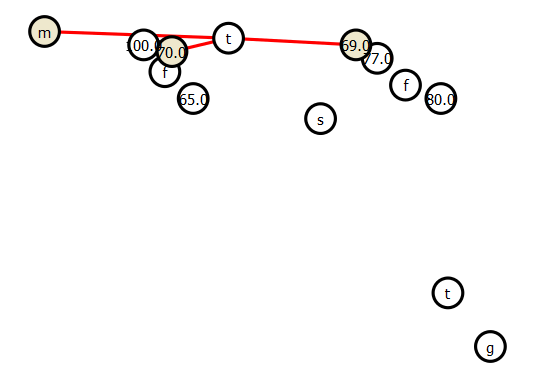

In [8]:
MOI.set(model, MOI.Silent(), true)
optimize!(model)

visualize_vnr(network, value.(x), value.(y))

In [9]:
#this is for when the JuMP constraints are not working; saves the constraints in a file
#CPXwriteprob( m.env, m.lp, "mymodel", "LP" );

## Analytical calculation of the optimization problem
Next, we will use a simple example in order to calculate if the above defined constraints correspond to the analytical solution calculated by hand.<br>
The example model used for the calculation will be a simple model with only two DER nodes. In order to further simplify the calculations, we will assume that the communication links between the towers and DERs have a reliability of $95\%$.

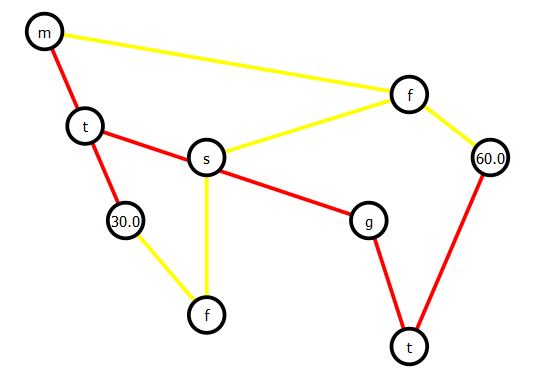

In [10]:
example_network = get_example()

visualize_network(example_network)

As mentioned in the scenario-based reliability calculation, the output reliability of the VPP can be calculated by considering the different reliability levels of the  two DER nodes. In order to simplify the calculation, we will only consider the pre-defined reliability levels $r\in \{0.1, 0.3, 0.5, 0.7, 0.9\}$.

In [11]:
example_reliabilities = [0.1, 0.3, 0.5, 0.7, 0.9]
scenario_outputs = create_scenarios(example_network.nodes, example_reliabilities)
display(scenario_outputs)

25-element Vector{Any}:
 (0.010000000000000002, [0.0, 0.0, 0.0, 47.184484344553994, 23.592242172276997, 0.0, 0.0, 0.0, 0.0])
 (0.03, [0.0, 0.0, 0.0, 47.184484344553994, 27.377997436459797, 0.0, 0.0, 0.0, 0.0])
 (0.05, [0.0, 0.0, 0.0, 47.184484344553994, 30.0, 0.0, 0.0, 0.0, 0.0])
 (0.06999999999999999, [0.0, 0.0, 0.0, 47.184484344553994, 32.62200256354021, 0.0, 0.0, 0.0, 0.0])
 (0.09000000000000001, [0.0, 0.0, 0.0, 47.184484344553994, 36.407757827723, 0.0, 0.0, 0.0, 0.0])
 (0.03, [0.0, 0.0, 0.0, 54.755994872919594, 23.592242172276997, 0.0, 0.0, 0.0, 0.0])
 (0.09, [0.0, 0.0, 0.0, 54.755994872919594, 27.377997436459797, 0.0, 0.0, 0.0, 0.0])
 (0.15, [0.0, 0.0, 0.0, 54.755994872919594, 30.0, 0.0, 0.0, 0.0, 0.0])
 (0.21, [0.0, 0.0, 0.0, 54.755994872919594, 32.62200256354021, 0.0, 0.0, 0.0, 0.0])
 (0.27, [0.0, 0.0, 0.0, 54.755994872919594, 36.407757827723, 0.0, 0.0, 0.0, 0.0])
 (0.05, [0.0, 0.0, 0.0, 60.0, 23.592242172276997, 0.0, 0.0, 0.0, 0.0])
 (0.15, [0.0, 0.0, 0.0, 60.0, 27.377997436459

When considering a desired reliability of $99.9\%$ for the VPP, we can thus only fail in scenarios where the cumulative scenario probabilities is less than $0.1\%$. 
Before analysing the generated scenarios, we first need to calculate the communication reliability factor that we multiply with the scenario probabilities. Given $\sum_{\omega \in \Omega}\pi_\omega=6.25$, this means that $\alpha(1-r_l) = 0.008$.<br>
Furthermore, since we only fail in scenarios where the power output is the lowest, we only regard the scenarios as "failable" in this example where one of the two DER fail and the DER mean value of $60$ or the DER with the mean value of $30$ have the lowest output level. Since we have 5 different reliability levels, there are therefore 5 scenarios with the lowest output level of each node of $47.18$ or $23.59$. Since $47.18>23.59$, we will here work with the power output value of  $23.59$.<br>
This means the only failable scenarios that we will consider here have a total probability of $0.008(1\%+3\%+5\%+7\%+9\%)=0.2\%$. Therefore, a VPP with an output of more than $23.59$ (and less than $27.377$) would have a reliability of $1-0.0002=99.8\%$.<br>
Considering the above written calculations, we will now consider two scenarios. In one scenario, the VPP embedding fails no scenarios. In the second scenario, the embedding fails since the desired power output is above $23.59$ and thus the reliability is less than $99.9\%$.<br> 
We use the two scenarios to check the JuMP constraints' correctness.

In [12]:
#example 1
example_vnr1 = VNR(23.0, 0.999)

#this function just re-runs the in this project defined JuMP constraints with the given network, vnr and scenario reliabilities
#put show_failures as true if you want to look at which scenarios the embedding fails
calculate_embedding(example_network, example_vnr1, example_reliabilities, show_embedding = false)

Academic license - for non-commercial use only
problem has optimal solution

In [13]:
#example 2
example_vnr2 = VNR(24.0, 0.9999)

#no embedding should be possible in this scenario
calculate_embedding(example_network, example_vnr2, example_reliabilities, show_embedding = false)

Academic license - for non-commercial use only
no solution could be found for the model

Our defined JuMP constraints show the same results as our analytical results.<br>
This means that our constraints are working as expected for this network, VNR and the defined reliability level.<br>
Lastly, let us check if an embedding can be found for our second example if we reduce the VNR's reliability to $99.98\%$.

In [14]:
#example 3
example_vnr3 = VNR(24.0, 0.998)

#an embedding should be possible in this scenario
calculate_embedding(example_network, example_vnr3, example_reliabilities, show_embedding = false)

Academic license - for non-commercial use only
problem has optimal solution

### Reducing the scenario amount
With the example, we could check that this project implements the defined constraints successfully. But, on the other side, we could also see that the implementation works only when the amount of used scenarios is kept small. Consequently, this means that the number of considered reliability levels and/or the model size needs to be small.<br>
This can be considered a big limitation factor that constraints our new approach. Therefore, the reduction of the scenario amount would improve the efficiency of our new scenario.<br>
Looking at the assumptions that were given in our constraint definitions, we know that a the failure reliability $1-r_i$ is high when the power output expectation $p_i$ is high. This means that when scenario probability $\prod_{n \in N}1-r_i$ is high the expected power output is high. Furthermore, this means that with decreasing scenario probability the expected power output of the substrate network also decreases.<br>
Therefore, if the VNE does not fail in a scenario with a lower power output, it will also not fail in a scenario with a higher output. Thus, we only need to consider scenarios with low probability.<br>
Finally, this leads us to only need to consider scenarios with low probabilities. Then, considering the fact that only scenarios with a cumulative probability less or equal to $1-r_{VNR}$ can fail, we can say for sure that scenarios with a probability higher than $1-r_{VNR}$ are not allowed to fail. As a consequence, we only need to consider the scenarios with a probability $u_i\leq1-r_{VNR}$ and the scenario with the smallest scenario probability where the condition $u_i>1-r_{VNR}$ holds true.<br>
In addition, we also need to consider the link failure scenarios. Since we calculate the total scenario probability as the product of the node scenario probabilities and a function of the link reliability, we can use the simple heuristic of calculating the lowest value that the function can have given the network link reliabilities and calculating the product of the probabilities and the lowest value.<br>
Now let us create the scenarios with the now defined heuristics:

In [15]:
create_minimum_scenarios(example_network.nodes, example_network.com_edges, example_reliabilities, example_vnr1.reliability)

25-element Vector{Any}:
 (0.010000000000000002, [0.0, 0.0, 0.0, 47.184484344553994, 23.592242172276997, 0.0, 0.0, 0.0, 0.0])
 (0.03, [0.0, 0.0, 0.0, 47.184484344553994, 27.377997436459797, 0.0, 0.0, 0.0, 0.0])
 (0.03, [0.0, 0.0, 0.0, 54.755994872919594, 23.592242172276997, 0.0, 0.0, 0.0, 0.0])
 (0.05, [0.0, 0.0, 0.0, 47.184484344553994, 30.0, 0.0, 0.0, 0.0, 0.0])
 (0.05, [0.0, 0.0, 0.0, 60.0, 23.592242172276997, 0.0, 0.0, 0.0, 0.0])
 (0.06999999999999999, [0.0, 0.0, 0.0, 47.184484344553994, 32.62200256354021, 0.0, 0.0, 0.0, 0.0])
 (0.06999999999999999, [0.0, 0.0, 0.0, 65.24400512708041, 23.592242172276997, 0.0, 0.0, 0.0, 0.0])
 (0.09, [0.0, 0.0, 0.0, 54.755994872919594, 27.377997436459797, 0.0, 0.0, 0.0, 0.0])
 (0.09000000000000001, [0.0, 0.0, 0.0, 47.184484344553994, 36.407757827723, 0.0, 0.0, 0.0, 0.0])
 (0.09000000000000001, [0.0, 0.0, 0.0, 72.815515655446, 23.592242172276997, 0.0, 0.0, 0.0, 0.0])
 (0.15, [0.0, 0.0, 0.0, 54.755994872919594, 30.0, 0.0, 0.0, 0.0, 0.0])
 (0.15, [0.0, 0

With this, we can reduce the scenario probability by a considerable amount. Therefore, we shuld now be able to process bigger network models and use a higher amount of reliability levels.

In [16]:
heuristics_reliabilities = [0.1, 0.3, 0.5, 0.7, 0.9]
heuristics_network = generate_network(3, 1)
heuristics_vnr = VNR(70.0, 0.95)
#without the heuristics, the scenario size would be 3^5 = 243

minimum_scenarios = create_minimum_scenarios(heuristics_network.nodes, heuristics_network.com_edges,
                                              heuristics_reliabilities, heuristics_vnr.reliability)

125-element Vector{Any}:
 (0.0010000000000000002, [0.0, 0.0, 0.0, 0.0, 29.937077881000103, 49.36509607964879, 64.3514474762978, 0.0, 0.0, 0.0, 0.0])
 (0.003, [0.0, 0.0, 0.0, 0.0, 29.937077881000103, 62.737980788244506, 64.3514474762978, 0.0, 0.0, 0.0, 0.0])
 (0.003, [0.0, 0.0, 0.0, 0.0, 43.56283921075803, 49.36509607964879, 64.3514474762978, 0.0, 0.0, 0.0, 0.0])
 (0.0030000000000000005, [0.0, 0.0, 0.0, 0.0, 29.937077881000103, 49.36509607964879, 79.5048202075795, 0.0, 0.0, 0.0, 0.0])
 (0.005000000000000001, [0.0, 0.0, 0.0, 0.0, 29.937077881000103, 49.36509607964879, 90.0, 0.0, 0.0, 0.0, 0.0])
 (0.005000000000000001, [0.0, 0.0, 0.0, 0.0, 29.937077881000103, 72.0, 64.3514474762978, 0.0, 0.0, 0.0, 0.0])
 (0.005000000000000001, [0.0, 0.0, 0.0, 0.0, 53.0, 49.36509607964879, 64.3514474762978, 0.0, 0.0, 0.0, 0.0])
 (0.006999999999999999, [0.0, 0.0, 0.0, 0.0, 29.937077881000103, 81.26201921175549, 64.3514474762978, 0.0, 0.0, 0.0, 0.0])
 (0.006999999999999999, [0.0, 0.0, 0.0, 0.0, 62.4371607892

In [17]:
#the calculation of an optimal embedding is now possible
calculate_embedding(heuristics_network, heuristics_vnr, heuristics_reliabilities, minimum_scenarios, show_failures = false,
show_embedding = false)

Academic license - for non-commercial use only
problem has optimal solution

## Analysis of realistic network and power consumption parameters
After defining and implementing all relevant constraints, we now should analyse a real life example of power output capabilities of DERs and local energy demand.<br>
One reliable source of weather data in Germany is the [German Weather Service (DWD)](https://www.dwd.de/DE/Home/home_node.html). They have a variety of useful information like sun and wind intensity in specific locations in their [database](https://opendata.dwd.de/climate_environment/CDC/).<br>
The city further examined in this project is Mannheim. The sun irradiance and wind speed in the city in 09/07/2018 is given by the DWD. The data is plotted below:
![real environmental parameters](fig/sun_and_wind_mannheim.png)<br>

With this, we can calculate the power that a solar panel and wind turbine could calculate in the specific day.<br>
First, we define the power output of the solar panels. We can calculate the average power generation with 
$P_{output\_per\_size} = panel\_efficiency \cdot time \cdot sun\_irradiance$. For this equation, we are working with an average of ca. 20% efficiency for power panels and we are calculating the power output for each 10 minutes.<br>
For the wind turbines, the [average power output](https://home.uni-leipzig.de/energy/energy-fundamentals/15.htm) can be calculated with $P_{output\_per\_unit} = \frac{\rho\cdot A \cdot v^3}{2}$. Considering an average rotor diameter of [120 m](http://windmonitor.iee.fraunhofer.de/windmonitor_en/3_Onshore/2_technik/4_anlagengroesse/), we can calculate the average surface area as $\pi \cdot(\frac{d}{2})^2 = 11309m^2$. For the air density $\rho$, we use the average air density $1.225 kg/m^3$.<br>
The power output generation based on the equations can be seen in the graph below:
![real power output](fig/power_generation_mannheim.png)
Next, we know the [power consumption of the city Mannheim in 2018](https://www.mannheim.de/sites/default/files/2021-03/CO2%20Bilanz%20Mannheim%202018.pdf). Unfortunately, we do not know the exact power demand for the specific day. Thus, we will work with the average daily power demand of $\frac{10480GWh}{365days*24h/day}=1.196GW$. We use this estimated demand and combine it with the [duck curve](https://en.wikipedia.org/wiki/Duck_curve) to create an appropriate load curve for an average day. The created curve can be seen in the graph below:
![estimated load curve](fig/load_mannheim.png)<br>
Then, we also need appropriate energy prices to calculate our example. For simplification, we will work with a fixed price of $0.3€/kW$.<br>
Finally, we need to know an appropriate, realistic distribution of solar panels and wind turbines in our example model. In 2019, [50% of the green energy produced in germany was generated by wind turbines and 20% generated by solar panels, with 30% being generated by other renewable sources (water, biomass,...).](https://www.bmwi.de/Redaktion/DE/Dossier/erneuerbare-energien.html)
For this example, we will ignore the other renewable sources and work with a model that where 65% of the DERs are wind turbines and 35% are solar panels.<br>
With this, we have enough information to use our VNE mapping approach in a realistic example. In this example, we generate an example model that should represent Mannheim and that will generate a power output dependent on the solar irradiation and wind intensity in plotted in the graphs above. Then, we will observe if there are any dynamic changes on the embedding during the day when using our defined constraints.

Academic license - for non-commercial use only
calculation time: 00:00:55.22

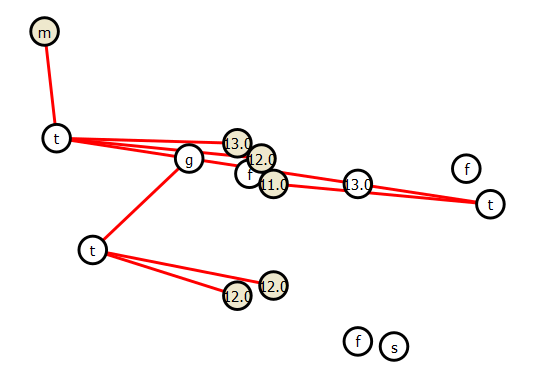

In [18]:
#the price used for our example
unit_price = .3

#model size parameters
clusters = 3
nodes_per_cluster = 2

used_model = generate_network(clusters, nodes_per_cluster)
used_time = 12

dynamic_model_analysis(.95, model = used_model, times = used_time, type = "exact", lambda = unit_price, 
        update = true, scale = 10^3)

Next, let us compare our approach with less complex approaches and check if the results show significant differences.<br>
The first simplified approach will be called the "heuristic approach". In this approach, we describe the node scenarios and the link failure scenarios independently from each other. 
Thus, we have two different constraint groups. The node scenario constraint was already explained and is defined as
$$ \zeta_\omega = \begin{cases}
    1 & \text{if $\sum_{n \in N}p_{n,\omega}(r'_{n,\omega})x_n< p$}\\ 
    0 & \text{otherwise.}
\end{cases}$$
and the reliability can be calculated as:
$$ \sum_{\omega \in \Omega}\zeta_\omega\pi_\omega \leq 1-r$$<br>
Then, we calculate the link failure constraints not with all possible node outputs, but only with the mean node output. Thus, the corresponding constraints are defined as 
$$ \zeta_{l} = \begin{cases}
    1 & \text{if $\sum_{n \in N}p_{n}x_n\epsilon_l(n)< p$}\\ 
    0 & \text{otherwise.}
\end{cases}$$
where the variable $\epsilon_l(n)$ in the equation defines that if a node $n$ cannot be connected anymore when the link $l$ fails. The link reliability is then also calculated as 
$$ \sum_{l \in L}\zeta_l\pi_l \leq 1-r$$<br>

In [19]:
#scenario variables 
#@variable(model,zeta[1:length(scenario_outputs)], binary = true)
#@variable(model,zeta_link[1:length(network.com_edges)], binary = true)

#then, add the new constraints
#node constraints
#@constraint(model, c14[i = 1:length(scenario_outputs)], zeta[i]*vnr.power 
#    + sum(x[2,n]*scenario_outputs[i][2][n] for n in 1:length(network.nodes)) >= vnr.power)

#@constraint(model, c15, sum(zeta[i]*scenario_outputs[i][1] for i in 1:length(scenario_outputs)) <= 1.0-vnr.reliability)

#link constraints
#@constraint(model, c16[l = 1:length(network.com_edges)], zeta_link[l]*vnr.power
#        + sum(x[2,n]*network.nodes[n].power*epsilon[l, n] for n in 1:length(network.nodes)) >= vnr.power)

#@constraint(model, c17, sum(zeta_link[l]*network.com_edges[l].reliability
#                            for l in 1:length(network.com_edges)) <= 1.0-vnr.reliability)

Academic license - for non-commercial use only
calculation time: 00:00:0.34

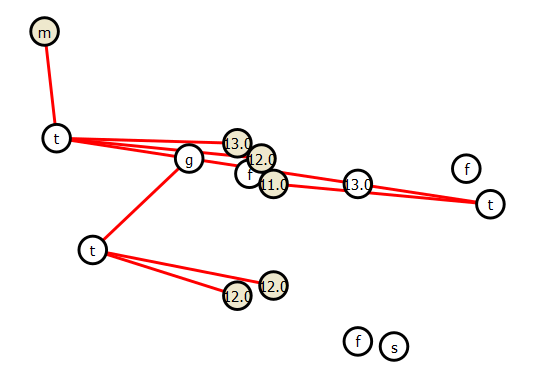

In [20]:
#now use the constraints in our realistic example

dynamic_model_analysis(.95, model = used_model, times = used_time, type = "heuristic", lambda = unit_price, scale = 10^3)

For the next approach, that is called the "simple" approach, we will ignore the idea of creating scenarios by analyzing the possible DER outputs in its entirety and only work with the mean outputs. This leads us to modify our previously defined constraints in such a way, so that we only need the constraint: 
$$\sum_{n \in N}p_{n}x_n< p$$
The link failure scenarios also need to be considered in this approach. For this, the constraints used in the heuristic approach are used. The reliability of the embedding is then calculated by using the link failure scenario's reliability constraint.

In [21]:
#@variable(model,zeta_link[1:length(network.com_edges)], binary = true)   
#node constraints
#@constraint(model, c14, sum(x[2,n]*network.nodes[n].power for n in 1:length(network.nodes)) >= vnr.power)

#link constraints
#@constraint(model, c15[l = 1:length(network.com_edges)], zeta_link[l]*vnr.power
#        + sum(x[2,n]*network.nodes[n].power*epsilon[l, n] for n in 1:length(network.nodes)) >= vnr.power)

#@constraint(model, c16, sum(zeta_link[l]*network.com_edges[l].reliability
#                            for l in 1:length(network.com_edges)) <= 1.0-vnr.reliability)

Academic license - for non-commercial use only
calculation time: 00:00:0.06

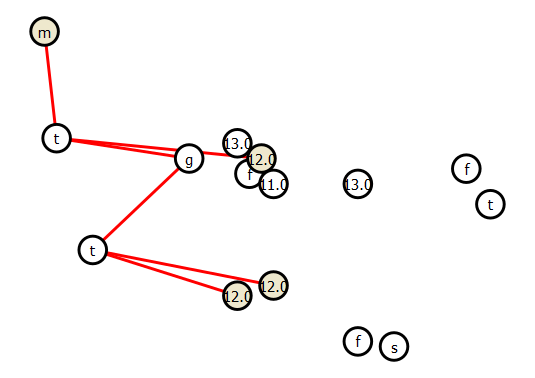

In [22]:
dynamic_model_analysis(.95, model = used_model, times = used_time, type = "simple", lambda = unit_price, scale = 10^3)

Lastly, let us analyse the last approach, called the "no_link_failure" approach, where we ignore all link failure scenarios and only consider the main power output of the nodes. This means, the only constraint considered in this approach is the node constraint defined in the "simple" approach. Thus, the only scenario constraint considered in this approach is 
$$\sum_{n \in N}p_{n}x_n< p$$

Academic license - for non-commercial use only
calculation time: 00:00:0.01

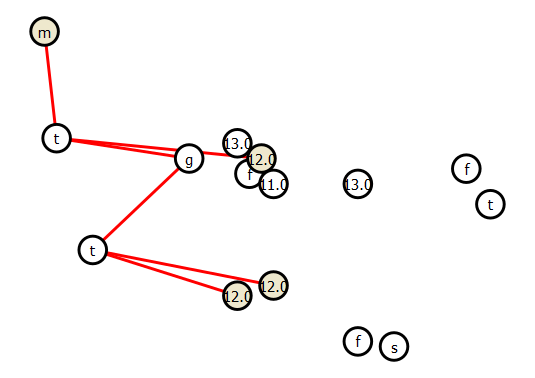

In [23]:
dynamic_model_analysis(.95, model = used_model, times = used_time, type = "no_link_failure", lambda = unit_price, scale = 10^3)

Therefore, we can derive from the results of the three different constraint sets that the exact solution that was introduced in this project normally creates the most reliable embeddings by creating more redundancy when calculating the embeddings. On the other side, the generated redundancy leads to the embedding being more costly than the embeddings created by the simpler constraint sets and sometimes an embedding is not even possible since the strict reliability constraints couldn't be met.<br>
Furthermore, there is the practical limitation of the exact solution being much more time-consuming to solve than the heuristic or the simple solution since it needs to solve much more constraints (that also increase in a much higher rate than the simpler constraint sets). This leads us to only be able to calculate the embeddings of small models.<br>
Finally, let us compare the performance and the results of the 4 different approaches. For this, we calculate the reliability based on the strictest definition given in this project. This means that the reliability $r_{VPP}$ of an embedding is calculated with the equation:
$$ 1-(\sum_{\omega \in \Omega, l \in L}\zeta_{\omega, l}\pi_\omega\frac{1}{\sum_{\omega \in \Omega}\pi_\omega}(1-r_l) +\sum_{\omega \in \Omega}\zeta_{\omega,|L|+1}\pi_\omega) =r$$
<br>
Based on this equation, a testbench was created where the reliability of the embedding and the calculation time to solve the constraints was measured with increasing model size. The reliability levels used for this evaluation were $rel = [0.4, 0.5, 0.6]$. For each model size, the embedding was calculated in $5$ iterations where for each iteration a new model was generated. The power demand also increased with the model size, and was calculated as $p_{VPP}=0.35 \sum_{n \in N}p_i$. The reliability of the VPP remained static for the entire evaluation with $r_{VPP}=0.9$. The results can be seen in the plots below:
<table border="1">
<tr>
<td><center><strong>Time</strong></center></td>
<td><center><strong>Reliability</strong></center></td>
</tr>
<tr>
<td><img src="scripts/fig/time.png" width="95%" /> </td>
<td><img src="scripts/fig/reliability.png" width="95%" /> </td>
</tr></table>
From the results, one can see that the reliability varies with the model size. The reason is that, with increased model size and desired power output of the VPP, the amount of nodes that need to be activated in all approaches increases. As a consequence, if the VPP output reaches a size where an additional node needs to be activated, the reliability reached in the specific model size is usually higher than of the next smaller model size since the additional node leads to a higher reliability of the embedding. In addition, it becomes obvious that the exact approach only leads to slightly better results than the heuristic approach. This leads us to assume that even in general cases, the exact approach may only be able to calculate slightly better approaches than the heuristic approach.<br>
Next, we can see that calculation time for the exact approach increases much higher than for the other approaches (For these subplots, please pay attention to the y-axis since the plotting library was unable to make all subplots both be in log-scale and also have the same values on the y-axis). This was expected since the number of constraints that need to be considered in the exact approach are much higher than for the other three approaches. But, on the other side, the reliability data shows that it can generate more reliable embeddings than the other approaches. <br>
Furthermore, when comparing the exact and the heuristic approach, we can observe that the heuristic approach needs much less computation time than the exact approach. This leads to the conclusion that since the exact approach is only slightly better than the heuristic approach while being much more computationally expensive, that the heuristic approach is the more practical approach of the two. The other two approaches cannot be considered as practical as the heuristic approach since their results are very unreliable, even though they can be computed fast. <br><br>
Now let us observe the results when more extreme reliability levels are used to calculate the embedding. The levels were changed to $rel = [0.2, 0.5, 0.8]$ and the power output was calculated as $p_{VPP}=0.2 \sum_{n \in N}p_i$. The other parameters remained the same.
<table border="1">
<tr>
<td><center><strong>Time</strong></center></td>
<td><center><strong>Reliability</strong></center></td>
</tr>
<tr>
<td><img src="scripts/fig/time0.2.png" width="95%" /> </td>
<td><img src="scripts/fig/reliability0.2.png" width="95%" /> </td>
</tr></table>
In this testbench, we can see that the reliability of the embeddings calculated with the two simpler methods is on average lower than when using the former reliability levels. This makes sense since we consider more extreme output scenarios where additional node activations are more necessary to compensate for the low output. But this example also shows that the heuristic approach calculates results that are as reliable as the exact approach.<br>
